In [11]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser
from dateutil import rrule

from sklearn.metrics import auc, roc_curve, classification_report


%matplotlib inline
sns.set(style="white",context="talk")

In [12]:
# from google.colab import drive
# drive.mount("/content/drive")

# Goal
1. **A full picture of funnel conversion rate** for both **desktop and mobile**
2. Some **insights on what the product team should focus on** in order to improve
conversion rate as well as anything you might discover that could help improve

# 1. Load and merge the data

In [13]:
# Load the conversion project dataset
user_table = pd.read_csv("user_table.csv", sep = ",")
home_page_table = pd.read_csv("home_page_table.csv", sep = ",")
search_page_table = pd.read_csv("search_page_table.csv", sep = ",")
payment_page_table = pd.read_csv("payment_page_table.csv", sep = ",")
payment_confirmation_table = pd.read_csv("payment_confirmation_table.csv", sep = ",")

In [14]:
# Merge the data
data = pd.merge(left = user_table, right = home_page_table, how = "left", on = "user_id")
data = pd.merge(left = data, right = search_page_table, how = "left", on = "user_id")
data = pd.merge(left = data, right = payment_page_table, how = "left", on = "user_id")
data = pd.merge(left = data, right = payment_confirmation_table, how = "left", on = "user_id")

data.columns = ["user_id","date",	"device","sex","is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"]

# change the textual description into labels
for col in ["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"]:
    data.loc[(data[col].notnull()),col] = 1

# change the NA(people who never been to that funnel stage) into 0
data = data.fillna(0)
data

,user_id,date,device,sex,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
0,450007,2015-02-28,Desktop,Female,1,0,0,0
1,756838,2015-01-13,Desktop,Male,1,0,0,0
2,568983,2015-04-09,Desktop,Male,1,1,0,0
3,190794,2015-02-18,Desktop,Female,1,1,0,0
4,537909,2015-01-15,Desktop,Male,1,0,0,0
...,...,...,...,...,...,...,...,...
90395,307667,2015-03-30,Desktop,Female,1,0,0,0
90396,642989,2015-02-08,Desktop,Female,1,1,0,0
90397,659645,2015-04-13,Desktop,Male,1,1,0,0
90398,359779,2015-03-23,Desktop,Male,1,0,0,0


In [15]:
# Exploring the data types, number of unique values and missing values
# All the tables refer to only the user first experience on the site. 
print(f"The new customer journey consists of {data.shape[0]} rows and {data.shape[1]} columns, with 0 missing values\n")
pd.DataFrame({"data_types":data.dtypes, 
          "value_counts": data.nunique(),
          "null_counts": data.isnull().sum()}).set_index(data.dtypes.index)

The new customer journey consists of 90400 rows and 8 columns, with 0 missing values



,data_types,value_counts,null_counts
user_id,int64,90400,0
date,object,120,0
device,object,2,0
sex,object,2,0
is_home_pg,int64,1,0
is_search_pg,int64,2,0
is_pmt_pg,int64,2,0
is_pmt_cf_pg,int64,2,0


# 2. Conversion Rate

## 2.1 Aggregated conversion Rate

In [16]:
pd.DataFrame({
    "Customer journey": data[["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"]].sum().index,
    "Number of customers":data[["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"]].sum().values,
    "Percentage of customers": data[["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"]].sum().values/90400})

,Customer journey,Number of customers,Percentage of customers
0,is_home_pg,90400,1.000000
1,is_search_pg,45200,0.500000
2,is_pmt_pg,6030,0.066704
3,is_pmt_cf_pg,452,0.005000


How many people have reached each phase of the funnel?

In [17]:
data.groupby("device")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum()

,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
device,,,,
Desktop,60200,30100,3010,150
Mobile,30200,15100,3020,302


## 2-2. Overall Conversion Rate
By device

In [18]:
desktop_conv = data.groupby("device")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean().loc["Desktop",:]
mobile_conv = data.groupby("device")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean().loc["Mobile",:]
data.groupby("device")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()

,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
device,,,,
Desktop,1.0,0.5,0.05,0.002492
Mobile,1.0,0.5,0.10,0.010000


In [20]:
# pyecharts: cannot display the plot, so I am not using pyecharts-funnel() as illustration here
def funnel_plot(df_conv):
    attrs = df_conv.index.tolist()
    attr_value = np.array(df_conv.values*100).tolist()

    funnel2 = Funnel("Overall Funnel Diagram",width=800, height=400, title_pos='center')
    funnel2.add(name="Conversion Rate per phase during customer journey",        # 指定图例名称
                attr=attrs,                 # 指定属性名称
                value = attr_value,         # 指定属性所对应的值
                is_label_show=True,         # 指定标签是否显示
                label_formatter='{b}{c}%',  # 指定标签显示的格式
                label_pos="outside",        # 指定标签的位置
                is_legend_show=False)       # 指定图例不显示图例

    funnel2.render("funnel.html")
    funnel2

## 2-3. Conversion rate at individual phase
By device

In [21]:
ind_conv = data.groupby("device")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum()
ind_conv.columns = ["to_home","home_to_search","search_to_pmt","pmt_to_cf"]

for i in [3,2,1]:
    ind_conv[ind_conv.columns[i]] = ind_conv[ind_conv.columns[i]]/ind_conv[ind_conv.columns[i-1]]
ind_conv["to_home"] = 1
ind_conv

,to_home,home_to_search,search_to_pmt,pmt_to_cf
device,,,,
Desktop,1,0.5,0.1,0.049834
Mobile,1,0.5,0.2,0.100000


## 2-4. T-test on conversion rate by device

In [22]:
from scipy import stats
desktop_conv_day = data[data.device == "Desktop"].groupby("date")["is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()
mobile_conv_day = data[data.device == "Mobile"].groupby("date")["is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()

In [23]:
def levene_t_test(data1, data2):
    #print("Data1: KS-Test",stats.kstest(data1, 'norm'))
    #print("Data1: KS-Test",stats.kstest(data2, 'norm'),"\n")
    t,p = stats.levene(data1,data2)
    print(f"Levene variance test: t={round(t,3)}, p={round(p,3)}")
    if p<0.05:
        print("----variance of the two group doesn't equal, reject the null hypothesis----")
        t,p = stats.ttest_ind(data1,data2, equal_var = False)
    else:
        t,p = stats.ttest_ind(data1,data2)
    print(f"Independent t-test: t={round(t,3)}, p={round(p,3)}")

In [31]:
levene_t_test(desktop_conv_day["is_search_pg"], mobile_conv_day["is_search_pg"])

Levene variance test: t=144.006, p=0.0
----variance of the two group doesn't equal, reject the null hypothesis----
Independent t-test: t=0.172, p=0.864


In [32]:
levene_t_test(desktop_conv_day["is_pmt_pg"], mobile_conv_day["is_pmt_pg"])

Levene variance test: t=82.07, p=0.0
----variance of the two group doesn't equal, reject the null hypothesis----
Independent t-test: t=-7.828, p=0.0


In [33]:
levene_t_test(desktop_conv_day["is_pmt_cf_pg"], mobile_conv_day["is_pmt_cf_pg"])

Levene variance test: t=115.736, p=0.0
----variance of the two group doesn't equal, reject the null hypothesis----
Independent t-test: t=-9.203, p=0.0


# 3. Analyze key determinant factor


### 3-1. Sex
Pretty much the same 

In [35]:
pd.DataFrame({
    "Customer journey": data.groupby("sex")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum().columns,
    "Number of female customers":data.groupby("sex")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum().loc["Female"].values,
    "Number of male customers":data.groupby("sex")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum().loc["Male"].values,
    "Percentage of female customers": data.groupby("sex")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum().loc["Female"].values/90400,
    "Percentage of male customers": data.groupby("sex")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].sum().loc["Male"].values/90400})

,Customer journey,Number of female customers,Number of male customers,Percentage of female customers,Percentage of male customers
0,is_home_pg,45075,45325,0.498617,0.501383
1,is_search_pg,22676,22524,0.250841,0.249159
2,is_pmt_pg,3100,2930,0.034292,0.032412
3,is_pmt_cf_pg,241,211,0.002666,0.002334


In [36]:
male_conv_day = data[data.sex == "Male"].groupby("date")["is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()
female_conv_day = data[data.sex == "Female"].groupby("date")["is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()

In [37]:
levene_t_test(male_conv_day["is_search_pg"], female_conv_day["is_search_pg"])

Levene variance test: t=0.253, p=0.616
Independent t-test: t=-0.425, p=0.671


In [38]:
levene_t_test(male_conv_day["is_pmt_pg"], female_conv_day["is_pmt_pg"])

Levene variance test: t=1.058, p=0.305
Independent t-test: t=-0.715, p=0.476


In [39]:
levene_t_test(male_conv_day["is_pmt_cf_pg"], female_conv_day["is_pmt_cf_pg"])

Levene variance test: t=2.558, p=0.111
Independent t-test: t=-1.152, p=0.25


## Date

In [40]:
data.date = list(map(lambda day: datetime.strptime(day, '%Y-%m-%d').date(),data.date))

In [42]:
#data = backup

Include weekday, week (assuming 4 weeks in a month), month(Jan ~ Dec)

In [43]:
# Weekday
wkday_dict = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
data['weekday'] = list(map(lambda x: wkday_dict[x.weekday()+1],data.date))

# Week_of_month (assuming 4 weeks in a month)
def get_week(day):
    if 1<= day.day < 8:
        return "1"
    elif 8<= day.day < 15:
        return "2"
    elif 15<= day.day < 22:
        return "3"
    else:
        return "4"
data["week"] = list(map(lambda day: get_week(day), data.date))

# Month
month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May"}
data["month"] = list(map(lambda day:month_dict[day.month], data.date))

data.head()

,user_id,date,device,sex,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg,weekday,week,month
0,450007,2015-02-28,Desktop,Female,1,0,0,0,Sat,4,Feb
1,756838,2015-01-13,Desktop,Male,1,0,0,0,Tue,2,Jan
2,568983,2015-04-09,Desktop,Male,1,1,0,0,Thu,2,Apr
3,190794,2015-02-18,Desktop,Female,1,1,0,0,Wed,3,Feb
4,537909,2015-01-15,Desktop,Male,1,0,0,0,Thu,3,Jan


### Weekday

In [44]:
data.groupby("weekday")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()

,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
weekday,,,,
Fri,1.0,0.502431,0.068314,0.004235
Mon,1.0,0.500425,0.067078,0.005944
Sat,1.0,0.511288,0.066010,0.005468
Sun,1.0,0.500077,0.066166,0.004798
Thu,1.0,0.499628,0.066870,0.004909
Tue,1.0,0.492400,0.067181,0.005434
Wed,1.0,0.493726,0.065311,0.004209


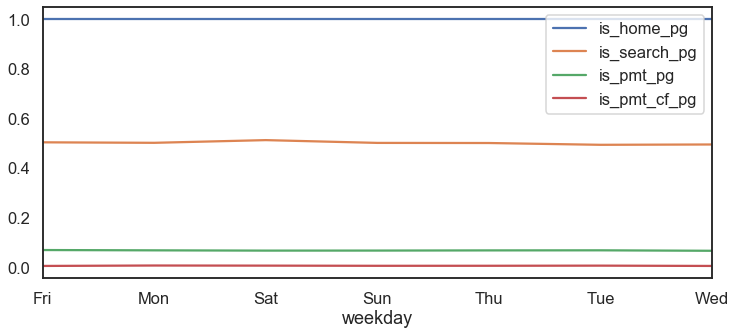

In [45]:
data.groupby("weekday")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean().plot(figsize = (12,5))

### Week

In [46]:
data.groupby("week")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()

,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
week,,,,
1,1.0,0.499104,0.066167,0.005942
2,1.0,0.501976,0.067997,0.004571
3,1.0,0.504257,0.069686,0.005090
4,1.0,0.495878,0.063816,0.004527


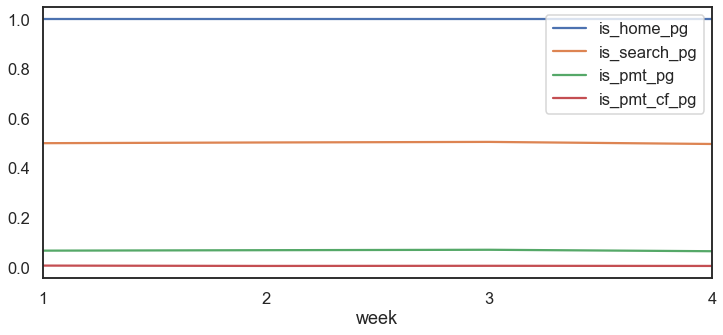

In [47]:
data.groupby("week")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean().plot(figsize = (12,5))

### Month

In [48]:
data.groupby("month")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean()

,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
month,,,,
Apr,1.0,0.401770,0.026416,0.002035
Feb,1.0,0.605619,0.106726,0.007655
Jan,1.0,0.599735,0.105752,0.008363
Mar,1.0,0.392876,0.027920,0.001947


In [51]:
data.groupby("month")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean().reset_index().sort_values(by="month")

,month,is_home_pg,is_search_pg,is_pmt_pg,is_pmt_cf_pg
0,Apr,1.0,0.401770,0.026416,0.002035
1,Feb,1.0,0.605619,0.106726,0.007655
2,Jan,1.0,0.599735,0.105752,0.008363
3,Mar,1.0,0.392876,0.027920,0.001947


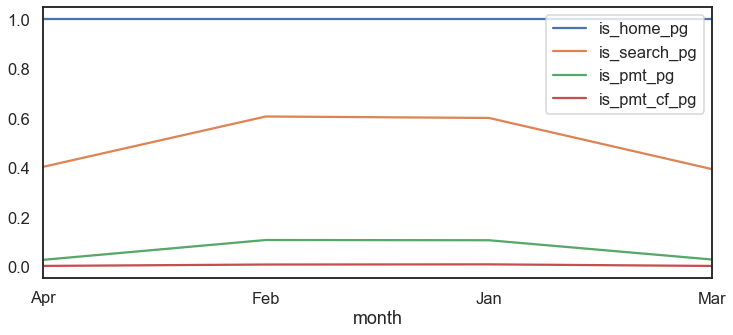

In [153]:
data.groupby("month")["is_home_pg","is_search_pg","is_pmt_pg","is_pmt_cf_pg"].mean().plot(figsize = (12,5))

In [54]:
conv_by_month = data.groupby(["date","month"])[["is_search_pg","is_pmt_pg","is_pmt_cf_pg"]].mean().reset_index()

In [218]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('is_search_pg ~ C(month)', conv_by_month[["month","is_search_pg"]]).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(month),3.0,1.265965,0.421988,1476.887104,3.340701e-92
Residual,116.0,0.033144,0.000286,NaN,NaN


In [219]:
model = ols('is_pmt_pg ~ C(month)', conv_by_month[["month","is_pmt_pg"]]).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(month),3.0,0.187277,0.062426,783.366269,8.484696e-77
Residual,116.0,0.009244,0.000080,NaN,NaN


In [220]:
model = ols('is_pmt_cf_pg ~ C(month)', conv_by_month[["month","is_pmt_cf_pg"]]).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(month),3.0,0.001090,0.000363,68.158465,1.753593e-25
Residual,116.0,0.000619,0.000005,NaN,NaN


# 4. OLS

coefficients of Month_Jan and Month_Feb are positive at 1% significant level

In [248]:
import statsmodels.api as sm

predictors = ['device', 'sex', 'weekday', 'month', 'week']

X = pd.get_dummies(data[predictors],drop_first = True)
y_search = data['is_search_pg']

X2 = sm.add_constant(X)
est = sm.OLS(y_search, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           is_search_pg   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     285.3
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:27:18   Log-Likelihood:                -63657.
No. Observations:               90400   AIC:                         1.273e+05
Df Residuals:                   90385   BIC:                         1.275e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3976      0.006     63.187

coefficients of Device_Mobile, Month_Jan and Month_Feb are positive at 1% significant level, while sex_Male is significantly negative at 5% level

In [249]:
est = sm.OLS(data["is_pmt_pg"], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              is_pmt_pg   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     228.6
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:27:21   Log-Likelihood:                -1200.3
No. Observations:               90400   AIC:                             2431.
Df Residuals:                   90385   BIC:                             2572.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0096      0.003      3.052

1. coefficients of Device_Mobile, Month_Jan and Month_Feb are positive at 1% significant level
2. weekday monday is significantly negative at 5% level

In [250]:
est = sm.OLS(data["is_pmt_cf_pg"], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           is_pmt_cf_pg   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     29.29
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           1.54e-78
Time:                        19:27:22   Log-Likelihood:             1.1164e+05
No. Observations:               90400   AIC:                        -2.233e+05
Df Residuals:                   90385   BIC:                        -2.231e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.001     -0.183